In [8]:
from tc_python import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from multiprocessing import Pool
import os
import math
import seaborn as sns

import matplotlib
matplotlib.rcParams['font.family'] = 'FreeSans'

In [9]:
basename = 'tc_MolarVolume'

current_directory = os.getcwd()
cache_fname = basename + '.ipynb' + "_cache"
output_fname = os.path.splitext(basename)[0]

print("Cache Filename: ", cache_fname)
print("Output Filename: ", output_fname)
print("Current Dir: ", current_directory)

Cache Filename:  tc_MolarVolume.ipynb_cache
Output Filename:  tc_MolarVolume
Current Dir:  /nethome/home3/yuxiang.wu/CCA_CALPHAD_SSS_ML/CCA_representation_ML/01_Dataset_Cleaned


### tc_calculation_Vm


In [10]:
def tc_calculation_Vm(tk, elements_list, k=40):
    # Setup thermodynamic calculation
    with TCPython() as start:
        calculation = (
            start
            .set_cache_folder(os.path.join(current_directory, cache_fname))
            .set_ges_version(5)
            .select_database_and_elements("tcfe11", elements_list)
            .deselect_phase("*")
            .select_phase("FCC_A1")
            .get_system()
            .with_batch_equilibrium_calculation()
            .set_condition(f"X({elements_list[0]})", 1E-2)
            .set_condition("T", 25+273.15)
            .disable_global_minimization()
        )

        # Generate condition combinations for equilibrium calculations
        list_of_conditions = [((f"X({elements_list[0]})", w), ("T", tk))
                              for w in np.linspace(1E-12, 0.9999999999, k)]
        # print(list_of_conditions)

        calculation.set_conditions_for_equilibria(list_of_conditions)

        results = calculation.calculate(
            ["vm(FCC_A1)"], 100)

        return (
            list_of_conditions,
            results.get_values_of('vm(FCC_A1)')
        )


tk = 298.15
elements_list_Co_all = [["Co", "Ti"],
                        ["Co", "Mo"],
                        ["Co", "V"],
                        ["Co", "Mn"],
                        ["Co", "Cr"],
                        ["Co", "Fe"],
                        ["Co", "Ni"],
                        ]
elements_list_Ni_all = [["Ni", "Ti"],
                        ["Ni", "Mo"],
                        ["Ni", "V"],
                        ["Ni", "Mn"],
                        ["Ni", "Cr"],
                        ["Ni", "Fe"],
                        ["Ni", "Co"],
                        ]
# elements_list_Ni_all = [["Ni", "Ti"],
#                         ]
k = 100

Vm_args_Co = [(tk, elements_list, k) for elements_list in elements_list_Co_all]
Vm_args_Ni = [(tk, elements_list, k) for elements_list in elements_list_Ni_all]

with Pool() as pool:
    Vm_results_Co = pool.starmap(tc_calculation_Vm, Vm_args_Co)
    Vm_results_Ni = pool.starmap(tc_calculation_Vm, Vm_args_Ni)

18:20:41,258 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

18:20:41,277 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

18:20:41,295 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

18:20:41,297 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

18:20:41,365 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

18:20:41,373 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

18:20:41,378 [Thread-1] INFO  CalculationEngine: Starting Thermo-Calc 2023b, Java-version: 14.0.2

18:20:42,722 [Thread-1] INFO  SystemBuilder: Found matching previous system

18:20:42,792 [Thread-1] INFO  SystemBuilder: Found matching previous system

18:20:42,799 [Thread-1] INFO  SystemBuilder: Found matching previous system

18:20:42,921 [Thread-1] INFO  SystemBuilder: Found matching previous system


In [11]:
print(Vm_results_Ni[0][0])

[(('X(Ni)', 1e-12), ('T', 298.15)), (('X(Ni)', 0.0101010101009899), ('T', 298.15)), (('X(Ni)', 0.020202020200979796), ('T', 298.15)), (('X(Ni)', 0.030303030300969695), ('T', 298.15)), (('X(Ni)', 0.040404040400959594), ('T', 298.15)), (('X(Ni)', 0.05050505050094949), ('T', 298.15)), (('X(Ni)', 0.06060606060093939), ('T', 298.15)), (('X(Ni)', 0.0707070707009293), ('T', 298.15)), (('X(Ni)', 0.0808080808009192), ('T', 298.15)), (('X(Ni)', 0.0909090909009091), ('T', 298.15)), (('X(Ni)', 0.101010101000899), ('T', 298.15)), (('X(Ni)', 0.11111111110088889), ('T', 298.15)), (('X(Ni)', 0.12121212120087879), ('T', 298.15)), (('X(Ni)', 0.1313131313008687), ('T', 298.15)), (('X(Ni)', 0.1414141414008586), ('T', 298.15)), (('X(Ni)', 0.1515151515008485), ('T', 298.15)), (('X(Ni)', 0.1616161616008384), ('T', 298.15)), (('X(Ni)', 0.17171717170082829), ('T', 298.15)), (('X(Ni)', 0.18181818180081818), ('T', 298.15)), (('X(Ni)', 0.19191919190080808), ('T', 298.15)), (('X(Ni)', 0.20202020200079798), ('T', 2

In [12]:
print(Vm_results_Ni[0][1][0])
print(Vm_results_Co[0][1][0])

9.99999999987194e-06
9.999999999873859e-06


In [13]:
def calculate_misfit(vm_FCC_L12, X_ele_A, X_ele_B, elements_list):
    avogadro_number = 6.02214179e23
    LP_FCC_L12 = np.power((4 * vm_FCC_L12 / avogadro_number), (1 / 3)) * 1e10
    VA_FCC_L12 = (vm_FCC_L12 / avogadro_number) * 1e30

    # Define element properties
    ele_all = ['Fe', 'Cr', 'Ni', 'Co', 'V', 'Mn',
               'Mo', 'Cu', 'Nb', 'W', 'Ti', 'Al', 'Si', 'Ta']
    molarV_matgen_ele = np.array(
        [7.09, 7.23, 6.59, 6.67, 8.32, 7.35, 9.38, 7.11, 10.83, 9.47, 10.64, 10.00, 12.06, 10.85])
    YM_matgen_ele = np.array([211.0, 279.0, 200.0, 209.0, 128.0,
                             198.0, 329.0, 130.0, 105.0, 411.0, 116.0, 70.0, 47.0, 186.0])
    BM_matgen_ele = np.array([170.0, 160.0, 180.0, 180.0, 160.0,
                             120.0, 230.0, 140.0, 170.0, 310.0, 110.0, 76.0, 100.0, 200.0])
    AtomicV_FCC_ele = np.array([11.375143, 12.441593, 10.932037, 11.122192, 14.685831, 12.665726,
                               15.924223, 11.794933, 17.893725, 16.509974, 17.647633, 16.570502, 14.431877, 18.140344])

    # Retrieve elements
    ele_A, ele_B = elements_list
    ele_indices = [ele_all.index(ele_A), ele_all.index(ele_B)]

    molarV_matgen = molarV_matgen_ele[ele_indices]
    YM_matgen = YM_matgen_ele[ele_indices]
    BM_matgen = BM_matgen_ele[ele_indices]
    AtomicV_FCC = AtomicV_FCC_ele[ele_indices]

    # Effective Moduli Calculation
    YM_eff = np.sum(np.outer(X_ele_A, molarV_matgen * YM_matgen),
                    axis=1) / np.sum(np.outer(X_ele_A, molarV_matgen), axis=1)
    BM_eff = np.sum(np.outer(X_ele_A, molarV_matgen * BM_matgen),
                    axis=1) / np.sum(np.outer(X_ele_A, molarV_matgen), axis=1)

    # Poisson's ratio and Shear modulus
    nu_eff = (1 - YM_eff / (3 * BM_eff)) / 2
    SM_eff = YM_eff / 2 / (1 + nu_eff)

    # Burgers vector
    b_FCC_L12 = (np.power(4 * VA_FCC_L12, 1 / 3)) / np.sqrt(2)

    # Misfit parameter
    delta_V_A = abs(AtomicV_FCC[0] - VA_FCC_L12)
    delta_V_B = abs(AtomicV_FCC[1] - VA_FCC_L12)
    delta_prime_misfit = np.sqrt(
        X_ele_A * delta_V_A ** 2 + X_ele_B * delta_V_B ** 2) / b_FCC_L12 ** 3

    return VA_FCC_L12, nu_eff, SM_eff, delta_prime_misfit


VA_FCC_L12_list_Co = []
nu_eff_list_Co = []
SM_eff_list_Co = []
delta_prime_misfit_list_Co = []

for i, elements_list_Co in enumerate(elements_list_Co_all):
    vm_FCC_L12 = np.array(Vm_results_Co[i][1])
    X_ele_A = np.linspace(1E-12, 0.9999999999, k)
    X_ele_B = 1 - X_ele_A

    # Function call
    (VA_FCC_L12,
     nu_eff, SM_eff,
     delta_prime_misfit) = calculate_misfit(vm_FCC_L12, X_ele_A, X_ele_B, elements_list_Co)

    VA_FCC_L12_list_Co.append(VA_FCC_L12)
    nu_eff_list_Co.append(nu_eff)
    SM_eff_list_Co.append(SM_eff)
    delta_prime_misfit_list_Co.append(delta_prime_misfit)


VA_FCC_L12_list_Ni = []
nu_eff_list_Ni = []
SM_eff_list_Ni = []
delta_prime_misfit_list_Ni = []

for i, elements_list_Ni in enumerate(elements_list_Ni_all):
    vm_FCC_L12 = np.array(Vm_results_Ni[i][1])
    X_ele_A = np.linspace(1E-12, 0.9999999999, k)
    X_ele_B = 1 - X_ele_A

    # Function call
    (VA_FCC_L12,
     nu_eff, SM_eff,
     delta_prime_misfit) = calculate_misfit(vm_FCC_L12, X_ele_A, X_ele_B, elements_list_Ni)

    VA_FCC_L12_list_Ni.append(VA_FCC_L12)
    nu_eff_list_Ni.append(nu_eff)
    SM_eff_list_Ni.append(SM_eff)
    delta_prime_misfit_list_Ni.append(delta_prime_misfit)

## Co-X


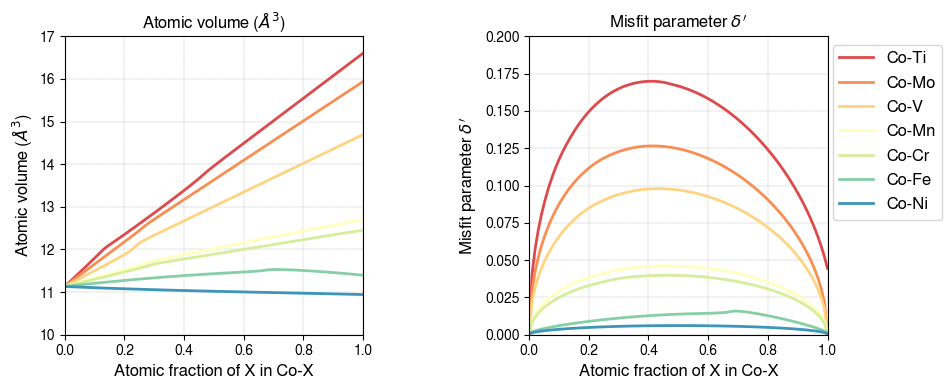

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True)
colors = sns.color_palette('Spectral', n_colors=len(elements_list_Co_all))

common_grid_settings = {'which': 'both',
                        'linestyle': '--', 'linewidth': 0.2, 'color': 'grey'}
common_plot_settings = {'linewidth': 2}

for i, (element_a, element_b) in enumerate(elements_list_Co_all):
    label = f"{element_a}-{element_b}"
    axs[0].plot(X_ele_B, VA_FCC_L12_list_Co[i], label=label,
                color=colors[i], **common_plot_settings)
    axs[1].plot(X_ele_B, delta_prime_misfit_list_Co[i],
                label=label, color=colors[i], **common_plot_settings)
    axs[0].set_ylim([10, 17])
    axs[1].set_ylim([0, 0.2])

    for ax, y_label, font_size in zip(axs, [r'Atomic volume ($\AA^3$)', r'Misfit parameter $\delta^\prime$'], [12, 12]):
        ax.grid(**common_grid_settings)
        ax.set_xlabel(r'Atomic fraction of X in Co-X', fontsize=font_size)
        ax.set_ylabel(y_label, fontsize=font_size)
        ax.set_title(y_label, fontsize=font_size)
        ax.set_box_aspect(1)
        ax.set_xlim([0, 1])


axs[1].legend(loc='upper center', bbox_to_anchor=(1.2, 1), fontsize=12)

plt.tight_layout()
plt.subplots_adjust(right=0.8)

plt_output_fname = "misfit_Co-X.pdf"
plt.savefig(os.path.join(current_directory, plt_output_fname),
            format='pdf', bbox_inches='tight')
plt.show()

## Ni-X


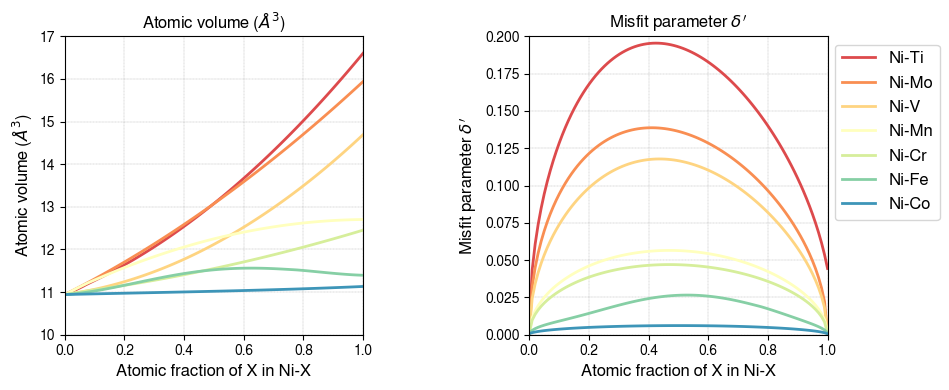

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True)

for i, (element_a, element_b) in enumerate(elements_list_Ni_all):
    label = f"{element_a}-{element_b}"
    axs[0].plot(X_ele_B, VA_FCC_L12_list_Ni[i], label=label,
                color=colors[i], **common_plot_settings)
    axs[1].plot(X_ele_B, delta_prime_misfit_list_Ni[i],
                label=label, color=colors[i], **common_plot_settings)
    axs[0].set_ylim([10, 17])
    axs[1].set_ylim([0, 0.2])

    for ax, y_label, font_size in zip(axs, [r'Atomic volume ($\AA^3$)', r'Misfit parameter $\delta^\prime$'], [12, 12]):
        ax.grid(**common_grid_settings)
        ax.set_xlabel(r'Atomic fraction of X in Ni-X', fontsize=font_size)
        ax.set_ylabel(y_label, fontsize=font_size)
        ax.set_title(y_label, fontsize=font_size)
        ax.set_box_aspect(1)
        ax.set_xlim([0, 1])

axs[1].legend(loc='upper center', bbox_to_anchor=(1.2, 1), fontsize=12)

plt.tight_layout()
plt.subplots_adjust(right=0.8)

plt_output_fname = "misfit_Ni-X.pdf"
plt.savefig(os.path.join(current_directory, plt_output_fname),
            format='pdf', bbox_inches='tight')
plt.show()